# Polymarket Backtesting & Live Trading — Complete Tutorial

This tutorial walks you through:

- **Part 1** — Fetching market data from Polymarket (no auth required)
- **Part 2** — Running a backtest on historical prediction-market data
- **Part 3** — Backtesting with synthetic data (offline / no API needed)
- **Part 4** — Connecting for live trading (requires wallet + API key)
- **Part 5** — Building your own strategy

## Prerequisites

Install required packages:
```bash
uv add requests py-clob-client python-dotenv
```

## Polymarket Documentation
- https://docs.polymarket.com/
- https://github.com/Polymarket/py-clob-client

## Setup and Imports

First, we'll import all necessary libraries and set up the project path.

In [6]:
from __future__ import annotations

import os
import sys

# Ensure project root is on path (works in Jupyter notebooks)
if 'get_ipython' in dir():
    # Running in Jupyter - use current working directory
    notebook_dir = os.getcwd()
    project_root = os.path.dirname(notebook_dir) if notebook_dir.endswith('polymarket') else notebook_dir
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
else:
    # Running as a script
    sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

---

# Part 1 — Fetching Market Data from Polymarket

The Polymarket API has two main services for reading data:

1. **Gamma API** (https://gamma-api.polymarket.com)
   - Discover markets, get metadata (question, outcomes, token IDs)
   - No authentication required
   - Key endpoints: `/markets`, `/events`

2. **CLOB API** (https://clob.polymarket.com)
   - Get historical prices, order books, midpoints
   - No auth for read endpoints
   - Key endpoint: `/prices-history`

Every market has two outcome tokens (e.g. YES / NO), each identified by a long hex `token_id`. Prices range from $0.01 to $0.99. A YES token at $0.65 means "the market thinks there's a 65% chance this happens."

In [14]:
from polymarket.data_client import PolymarketDataClient

client = PolymarketDataClient()

# List top markets by volume
print("=" * 70)
print("PART 1 — Fetching Market Data from Polymarket")
print("=" * 70)

print("\n📊 Fetching top 5 active markets by volume...")
markets = client.get_markets(limit=100, active=True, order="volume")

for i, m in enumerate(markets, 1):
    print(f"\n  [{i}] {m.question}")
    print(f"      Outcomes: {m.outcomes}")
    print(f"      Prices:   {m.outcome_prices}")
    print(f"      Volume:   ${m.volume:,.0f}")
    print(f"      YES token: {m.yes_token_id[:32]}...")
    print(f"      NO token:  {m.no_token_id[:32]}...")

if not markets:
    print("  (no markets returned — you may be offline)")

PART 1 — Fetching Market Data from Polymarket

📊 Fetching top 5 active markets by volume...

  [1] Counter-Strike: Acend vs Bebop (BO3) - CCT Europe Series #14 Play-In Group B
      Outcomes: ['Acend', 'Bebop']
      Prices:   [1.0, 0.0]
      Volume:   $10,000
      YES token: 13915383147598038388500755196666...
      NO token:  52791640825460131522088878907137...

  [2] Will the price of Bitcoin be above $110,000 on September 26 at 4AM ET?
      Outcomes: ['Yes', 'No']
      Prices:   [0.0, 1.0]
      Volume:   $100
      YES token: 10109368249695040244797052348281...
      NO token:  37839275698584141869811824793742...

  [3] Series: Most kills?
      Outcomes: ['4Pirates', 'Power Rangers']
      Prices:   [0.0, 1.0]
      Volume:   $1,000
      YES token: 10347501662810805466103346547239...
      NO token:  27568791610853645649922029176976...

  [4] Set 1 Winner: Lizunova vs Yoshida
      Outcomes: ['Lizunova', 'Yoshida']
      Prices:   [1.0, 0.0]
      Volume:   $1,000
      YES 

### Get Price History for Top Market

In [ ]:
if markets:
    top_market = markets[67]
    token_id = top_market.yes_token_id

    print(f"\n📈 Fetching price history for: {top_market.question[:60]}...")
    history = client.get_price_history(token_id, interval="1w", fidelity=60)

    print(f"   Got {len(history)} price points")
    if history:
        print(f"   First: t={history[0].timestamp}, p={history[0].price:.4f}")
        print(f"   Last:  t={history[-1].timestamp}, p={history[-1].price:.4f}")
else:
    top_market = None


📈 Fetching price history for: Will Wolves finish in last place in the 2025-26 English Prem...
   Got 169 price points
   First: t=1769220021, p=0.7160
   Last:  t=1769822175, p=0.7885
[PricePoint(timestamp=1769220021, price=0.716), PricePoint(timestamp=1769223638, price=0.7115), PricePoint(timestamp=1769227216, price=0.723), PricePoint(timestamp=1769230838, price=0.7235), PricePoint(timestamp=1769234437, price=0.7215), PricePoint(timestamp=1769238018, price=0.7175), PricePoint(timestamp=1769241620, price=0.7145), PricePoint(timestamp=1769245225, price=0.7145), PricePoint(timestamp=1769248829, price=0.7145), PricePoint(timestamp=1769252421, price=0.717), PricePoint(timestamp=1769256029, price=0.717), PricePoint(timestamp=1769259618, price=0.7145), PricePoint(timestamp=1769263226, price=0.7145), PricePoint(timestamp=1769266825, price=0.7145), PricePoint(timestamp=1769270418, price=0.7145), PricePoint(timestamp=1769274022, price=0.78), PricePoint(timestamp=1769277621, price=0.788), Price

/var/folders/l_/txq0vh11623_5lrnfw_cpmsh0000gn/T/ipykernel_25508/3074016735.py:11: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dates, prices, linestyle='solid')


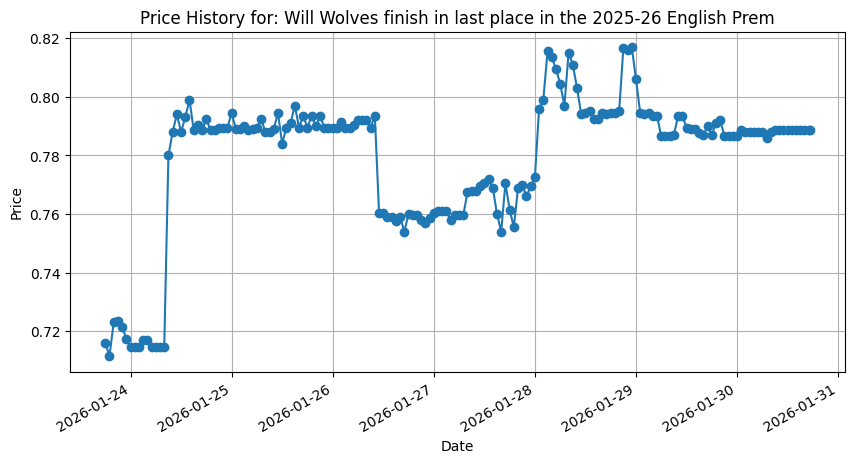

In [21]:
# Plot the history price against the timestamps
import matplotlib.pyplot as plt
# Convert timestamps to matplotlib datetime format
import matplotlib.dates as mdates
import datetime
if history:
    dates = [mdates.date2num(datetime.datetime.fromtimestamp(dp.timestamp)) for dp in history]
    prices = [dp.price for dp in history]

    plt.figure(figsize=(10, 5))
    plt.plot_date(dates, prices, linestyle='solid')
    plt.title(f"Price History for: {top_market.question[:60]}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.gcf().autofmt_xdate()  # Auto-format date labels
    plt.grid(True)
    plt.show()


---

# Part 2 — Backtesting on Real Polymarket Data

Fetch real historical data from Polymarket and run a backtest.

**Flow:**
1. Use PolymarketDataClient to get price history
2. Convert price history → Bar objects
3. Create a PredictionMarketOutcome instrument
4. Configure the backtest engine
5. Add a strategy and run

In [22]:
from decimal import Decimal

from nautilus_core.backtest.engine import BacktestEngine
from nautilus_core.enums import AccountType, OmsType
from nautilus_core.objects import Money

from polymarket.data_client import PolymarketDataClient
from polymarket.instruments import USDC, PredictionMarketOutcome
from polymarket.strategies import MomentumConfig, MomentumStrategy

print("\n" + "=" * 70)
print("PART 2 — Backtesting on Real Polymarket Data")
print("=" * 70)

client = PolymarketDataClient()

# Use market from Part 1, or fetch a new one
if top_market is None:
    print("\n  Fetching a high-volume market...")
    markets = client.get_markets(limit=1, active=True, order="volume")
    if not markets:
        print("  Cannot reach API — skipping Part 2 (try Part 3 for offline)")
    else:
        market = markets[0]
else:
    market = top_market

if market:
    token_id = market.yes_token_id
    print(f"\n  Market: {market.question[:70]}")
    print(f"  Token:  {token_id[:32]}...")

    # Fetch price history as Bar objects
    print("  Fetching historical prices (interval=max, fidelity=60)...")
    bars = client.get_price_history_as_bars(token_id, interval="max", fidelity=60)
    
    if len(bars) < 30:
        print(f"  Only {len(bars)} bars — not enough for a meaningful backtest.")
        print("  Try a more established market or Part 3 for synthetic data.")
    else:
        print(f"  Got {len(bars)} hourly bars")

        # Create instrument
        instrument = PredictionMarketOutcome(
            token_id=token_id,
            market_question=market.question,
            outcome_label=market.outcomes[0] if market.outcomes else "Yes",
            price_precision=4,
            size_precision=2,
        )

        # Setup engine
        engine = BacktestEngine()
        engine.add_venue(
            venue_name="POLYMARKET",
            oms_type=OmsType.NETTING,
            account_type=AccountType.CASH,
            base_currency=USDC,
            starting_balances=[Money("10000", USDC)],
        )
        engine.add_instrument(instrument)
        engine.add_data(bars)

        # Setup strategy
        config = MomentumConfig(
            instrument_id=str(instrument.id),
            fast_period=5,
            slow_period=15,
            trade_size=100,
            strategy_id="PolyMomentum",
        )
        strategy = MomentumStrategy(config)
        engine.add_strategy(strategy)
        strategy.subscribe_bars(bars[0].bar_type)

        # Run!
        print("\n  Running backtest...")
        engine.run()
        result = engine.get_result()
        print(result)


PART 2 — Backtesting on Real Polymarket Data

  Market: Will Wolves finish in last place in the 2025-26 English Premier League
  Token:  51084215309885045739879978888008...
  Fetching historical prices (interval=max, fidelity=60)...
  Got 742 hourly bars

  Running backtest...
BACKTEST RESULTS
  Start Time Ns                 : 1767146414000000000
  End Time Ns                   : 1769822535000000000
  Total Orders                  :           67
  Total Positions               :           34
  Total Fills                   :           67
  Starting Balance              :   10000.0000
  Ending Balance                :    9854.5000
  Total Return                  :    -145.5000
  Total Return Pct              :      -1.4550
  Total Commissions             :       0.0000
  Max Drawdown                  :     146.1000
  Max Drawdown Pct              :       1.4610
  Sharpe Ratio                  :      -0.1359
  Win Rate                      :       0.1212
  Profit Factor                 

---

# Part 3 — Backtesting with Synthetic Data (offline)

Run a backtest without needing API access by generating synthetic prediction-market data.

Prediction market prices are bounded [0, 1] so the synthetic data uses a **mean-reverting process (Ornstein-Uhlenbeck)** which is more realistic than a random walk for probabilities.

### Generate Synthetic Prediction Market Data

In [23]:
import math
import random
from decimal import Decimal

from nautilus_core.backtest.engine import BacktestEngine
from nautilus_core.data import Bar, BarSpecification, BarType
from nautilus_core.enums import (
    AccountType,
    BarAggregation,
    OmsType,
    PriceType,
)
from nautilus_core.identifiers import InstrumentId, Symbol, Venue
from nautilus_core.objects import Money, Price, Quantity

from polymarket.instruments import USDC, PredictionMarketOutcome
from polymarket.strategies import (
    MeanReversionConfig,
    MeanReversionStrategy,
    MomentumConfig,
    MomentumStrategy,
    ValueConfig,
    ValueStrategy,
)

print("\n" + "=" * 70)
print("PART 3 — Backtesting with Synthetic Prediction-Market Data")
print("=" * 70)

# Generate synthetic prediction market data
# Ornstein-Uhlenbeck process: mean-reverting around a central value
random.seed(42)
num_bars = 500
mu = 0.55       # long-run mean (true probability)
theta = 0.02    # mean reversion speed
sigma = 0.03    # volatility
price = 0.50    # starting price

token_id = "0x" + "a1b2c3d4" * 8  # fake token ID
instrument = PredictionMarketOutcome(
    token_id=token_id,
    market_question="Will event X happen by end of year?",
    outcome_label="Yes",
    price_precision=4,
    size_precision=2,
)

short_id = token_id[:16]
instrument_id = instrument.id
bar_spec = BarSpecification(60, BarAggregation.MINUTE, PriceType.MID)
bar_type = BarType(instrument_id, bar_spec)

base_ts = 1_700_000_000 * 1_000_000_000  # nanoseconds
bars = []

for i in range(num_bars):
    # OU step
    dp = theta * (mu - price) + sigma * random.gauss(0, 1)
    new_price = max(0.02, min(0.98, price + dp))

    open_px = price
    close_px = new_price
    high_px = min(0.99, max(open_px, close_px) + abs(random.gauss(0, sigma * 0.3)))
    low_px = max(0.01, min(open_px, close_px) - abs(random.gauss(0, sigma * 0.3)))

    ts = base_ts + i * 3_600_000_000_000  # hourly

    bars.append(Bar(
        bar_type=bar_type,
        open=Price(open_px, 4),
        high=Price(high_px, 4),
        low=Price(low_px, 4),
        close=Price(close_px, 4),
        volume=Quantity(0, 0),
        ts_event=ts,
        ts_init=ts,
    ))
    price = new_price

print(f"\n  Generated {len(bars)} synthetic bars")
print(f"  Price range: {bars[0].open} -> {bars[-1].close}")
print(f"  True probability (mu): {mu}")


PART 3 — Backtesting with Synthetic Prediction-Market Data

  Generated 500 synthetic bars
  Price range: 0.5000 -> 0.8416
  True probability (mu): 0.55


### Run Three Different Strategies

We'll compare three strategies on the same synthetic data:
1. **Mean Reversion** — Buys when price is below SMA, sells when above
2. **Momentum (EMA)** — Follows trend using fast/slow EMA crossovers
3. **Value** — Buys when market price is significantly below fair value

In [24]:
strategies_configs = [
    ("Mean Reversion", MeanReversionStrategy, MeanReversionConfig(
        instrument_id=str(instrument_id),
        sma_period=20,
        entry_threshold=0.05,
        exit_threshold=0.02,
        trade_size=100,
        strategy_id="MeanRev",
    )),
    ("Momentum (EMA)", MomentumStrategy, MomentumConfig(
        instrument_id=str(instrument_id),
        fast_period=5,
        slow_period=15,
        trade_size=100,
        strategy_id="Momentum",
    )),
    ("Value (fair=0.55)", ValueStrategy, ValueConfig(
        instrument_id=str(instrument_id),
        fair_value=0.55,
        edge_threshold=0.08,
        trade_size=100,
        strategy_id="Value",
    )),
]

for name, strategy_cls, config in strategies_configs:
    print(f"\n{'─' * 60}")
    print(f"  Strategy: {name}")
    print(f"{'─' * 60}")

    engine = BacktestEngine()
    engine.add_venue(
        venue_name="POLYMARKET",
        oms_type=OmsType.NETTING,
        account_type=AccountType.CASH,
        base_currency=USDC,
        starting_balances=[Money("10000", USDC)],
    )
    engine.add_instrument(instrument)
    engine.add_data(list(bars))  # copy since engine may modify

    strategy = strategy_cls(config)
    engine.add_strategy(strategy)
    strategy.subscribe_bars(bar_type)

    engine.run()
    result = engine.get_result()

    print(f"  Orders:   {result.total_orders}")
    print(f"  Fills:    {result.total_fills}")
    print(f"  PnL:      ${float(result.total_return):,.2f}")
    print(f"  Return:   {float(result.total_return / result.starting_balance * 100):.2f}%")
    print(f"  Drawdown: ${float(result.max_drawdown):,.2f}")


────────────────────────────────────────────────────────────
  Strategy: Mean Reversion
────────────────────────────────────────────────────────────
  Orders:   26
  Fills:    26
  PnL:      $38.70
  Return:   0.39%
  Drawdown: $65.26

────────────────────────────────────────────────────────────
  Strategy: Momentum (EMA)
────────────────────────────────────────────────────────────
  Orders:   37
  Fills:    37
  PnL:      $-73.57
  Return:   -0.74%
  Drawdown: $73.80

────────────────────────────────────────────────────────────
  Strategy: Value (fair=0.55)
────────────────────────────────────────────────────────────
  Orders:   8
  Fills:    8
  PnL:      $48.94
  Return:   0.49%
  Drawdown: $46.06


---

# Part 4 — Live Trading Demo

Demonstrates how to connect and trade on Polymarket.

⚠️ **This will NOT place real orders unless you uncomment the trading lines.** It only demonstrates the connection and read operations.

## Setup:
1. Copy `.env.example` to `.env`
2. Fill in your `POLYMARKET_PRIVATE_KEY` and `POLYMARKET_WALLET_ADDRESS`
3. Install: `uv add py-clob-client python-dotenv`
4. Fund your wallet with USDC on Polygon
5. Approve token allowances (see py-clob-client docs)

In [25]:
print("\n" + "=" * 70)
print("PART 4 — Live Trading Setup")
print("=" * 70)

# Load environment
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    print("  Install python-dotenv:  uv add python-dotenv")

pk = os.environ.get("POLYMARKET_PRIVATE_KEY", "")
if not pk or pk == "your_private_key_here":
    print("""
  ┌─────────────────────────────────────────────────────────────────┐
  │  No credentials found.  To enable live trading:                │
  │                                                                │
  │  1. Copy .env.example → .env                                   │
  │  2. Set POLYMARKET_PRIVATE_KEY  (your Polygon wallet PK)       │
  │  3. Set POLYMARKET_WALLET_ADDRESS  (your wallet address)       │
  │  4. Make sure you have USDC on Polygon and allowances set      │
  │                                                                │
  │  See:  https://github.com/Polymarket/py-clob-client            │
  └─────────────────────────────────────────────────────────────────┘
    """)
else:
    from polymarket.live_client import PolymarketLiveClient
    from polymarket.data_client import PolymarketDataClient

    print("\n  Connecting to Polymarket...")
    live = PolymarketLiveClient()
    live.connect()
    print("  Connected!")

    # Fetch a market to trade
    data = PolymarketDataClient()
    markets = data.get_markets(limit=1, active=True, order="volume")
    if not markets:
        print("  No markets available")
    else:
        market = markets[0]
        token_id = market.yes_token_id
        print(f"\n  Market: {market.question[:60]}")
        print(f"  YES price: {market.yes_price:.4f}")
        print(f"  NO price:  {market.no_price:.4f}")

        # Get live midpoint
        mid = data.get_midpoint(token_id)
        print(f"  Live midpoint: {mid:.4f}")

        # Show open orders
        orders = live.get_open_orders()
        print(f"\n  Open orders: {len(orders)}")

        # Example: place a limit buy (COMMENTED OUT for safety)
        print("""
  ┌─────────────────────────────────────────────────────────────────┐
  │  To place a real order, uncomment the lines below.             │
  │                                                                │
  │  # Buy 10 YES shares at $0.50                                  │
  │  result = live.buy_limit(token_id, price=0.50, size=10.0)      │
  │  print(result)                                                 │
  │                                                                │
  │  # Market buy $5 worth of YES shares                           │
  │  result = live.buy_market(token_id, amount=5.0)                │
  │  print(result)                                                 │
  │                                                                │
  │  # Cancel all orders                                           │
  │  live.cancel_all_orders()                                      │
  └─────────────────────────────────────────────────────────────────┘
        """)


PART 4 — Live Trading Setup

  Connecting to Polymarket...
  Connected!

  Market: Counter-Strike: Acend vs Bebop (BO3) - CCT Europe Series #14
  YES price: 1.0000
  NO price:  0.0000


HTTPError: 404 Client Error: Not Found for url: https://clob.polymarket.com/midpoint?token_id=13915383147598038388500755196666377480504116216295452377454618635607632089106

---

# Part 5 — Building Your Own Strategy

How to build a custom Polymarket strategy.

This section provides a comprehensive guide on creating custom trading strategies for prediction markets.

In [ ]:
print("\n" + "=" * 70)
print("PART 5 — Building Your Own Strategy")
print("=" * 70)
print("""
  STEP 1: Define a Config dataclass
  ──────────────────────────────────
  Extend StrategyConfig with your parameters:

    class MyConfig(StrategyConfig):
        def __init__(self, instrument_id, ...):
            super().__init__(strategy_id="MyStrategy")
            self.instrument_id_str = instrument_id
            # your params here

  STEP 2: Implement the Strategy
  ──────────────────────────────
  Override on_start(), on_bar(), and optionally on_stop():

    class MyStrategy(Strategy):
        def on_start(self):
            self.instrument_id = InstrumentId.from_str(...)

        def on_bar(self, bar: Bar):
            price = bar.close.as_double()

            # Your logic here — check indicators, signals, etc.

            # To buy:
            order = self.order_factory.market(
                instrument_id=self.instrument_id,
                side=OrderSide.BUY,
                quantity=instrument.make_qty(100),
                ts_init=bar.ts_event,
            )
            self.submit_order(order)

            # To sell / close:
            self.close_all_positions(self.instrument_id)

  STEP 3: Wire it up
  ──────────────────
    engine = BacktestEngine()
    engine.add_venue("POLYMARKET", ...)
    engine.add_instrument(instrument)
    engine.add_data(bars)

    strategy = MyStrategy(config)
    engine.add_strategy(strategy)
    strategy.subscribe_bars(bar_type)

    engine.run()
    print(engine.get_result())

  STEP 4: Go live
  ───────────────
  Once your backtest results look good, use PolymarketLiveClient
  to place real orders with the same logic:

    live = PolymarketLiveClient()
    live.connect()
    live.buy_limit(token_id, price=0.50, size=10.0)

  Key tips for prediction markets:
  ─────────────────────────────────
  • Prices are probabilities (0.01 – 0.99), NOT stock prices
  • Mean-reversion works better than momentum in most markets
  • Account for the bid-ask spread (often 2-5 cents)
  • Markets resolve to $1.00 or $0.00 — factor this binary payoff
  • Liquidity varies wildly between markets
  • Check the resolution source and end date before trading
""")